In [35]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [36]:
df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Germany,India,US,China,Spain,Italy
0,2020-01-22,0,0,1,548,0,0
1,2020-01-23,0,0,1,643,0,0
2,2020-01-24,0,0,2,920,0,0
3,2020-01-25,0,0,2,1406,0,0
4,2020-01-26,0,0,5,2075,0,0


In [37]:
N0=80000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Italy[20]
S0=N0-I0
R0=0

In [38]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0           
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [39]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recovered':R0})



for each_t in np.arange(500):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

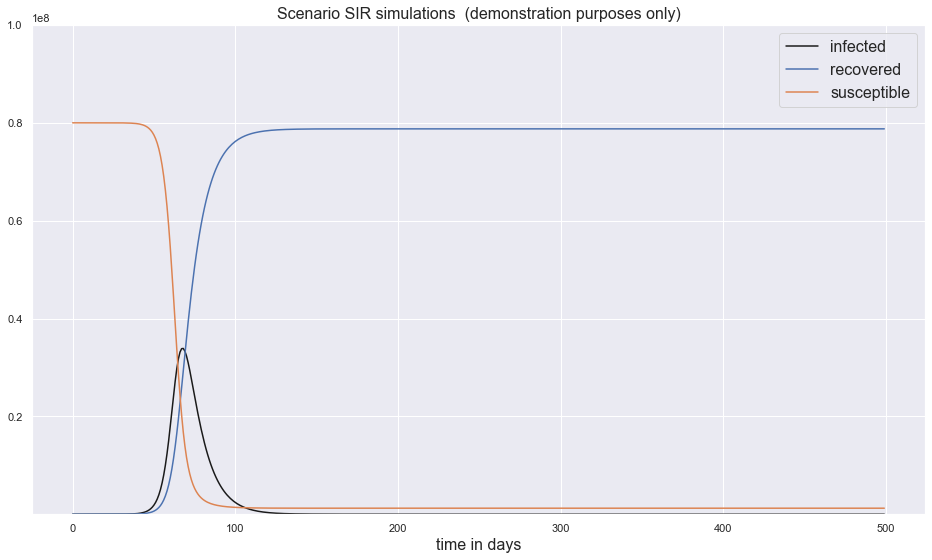

In [40]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 100000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [41]:
ydata = np.array(df_analyse.Germany[20:150])
t=np.arange(len(ydata))

In [42]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [43]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0           
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [44]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] 

In [45]:
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([1.60000000e+01, 2.15977389e+01, 2.91538940e+01, 3.93536328e+01,
       5.31218331e+01, 7.17069467e+01, 9.67942022e+01, 1.30658412e+02,
       1.76370235e+02, 2.38074596e+02, 3.21366505e+02, 4.33798337e+02,
       5.85564549e+02, 7.90425891e+02, 1.06695683e+03, 1.44022917e+03,
       1.94408432e+03, 2.62419976e+03, 3.54222700e+03, 4.78137478e+03,
       6.45394114e+03, 8.71147244e+03, 1.17584618e+04, 1.58708127e+04,
       2.14207138e+04, 2.89101251e+04, 3.90158179e+04, 5.26498745e+04,
       7.10408145e+04, 9.58421245e+04, 1.29276980e+05, 1.74330384e+05,
       2.35002717e+05, 3.16641526e+05, 4.26370646e+05, 5.73635988e+05,
       7.70883119e+05, 1.03436829e+06, 1.38507441e+06, 1.84964507e+06,
       2.46114758e+06, 3.25931512e+06, 4.28969511e+06, 5.60088173e+06,
       7.23885442e+06, 9.23763216e+06, 1.16063442e+07, 1.43146779e+07,
       1.72811838e+07, 2.03707212e+07, 2.34062647e+07, 2.61951879e+07,
       2.85629780e+07, 3.03828774e+07, 3.15917690e+07, 3.21894531e+07,
      

In [46]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\kaust\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-43-236eddffe712>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-43-236eddffe712>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-43-236eddffe712>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\kaust\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



standard deviation errors :  [0.03549598 0.03543885]  start infect: 16
Optimal parameters: beta = 1.3802987787091685  and gamma =  1.2745613962467366


In [47]:
# Calculating SIR fit of all countries using for loop

a = []
country_list = ['Germany','India','US','Italy','Spain']
for each in country_list:
    
    ydata = np.array(df_analyse[each][20:150])
    
    I0=ydata[0]
    S0=N0-I0
    R0=0
    beta
    
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))
    
    fitted=fit_odeint(t, *popt)
    a.append(fitted)

<ipython-input-43-236eddffe712>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-43-236eddffe712>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-43-236eddffe712>:18: RuntimeWarning:

overflow encountered in double_scalars



In [48]:
# Infected population data extraction for selected countries

extract_columns = pd.DataFrame(np.array(df_analyse.iloc[:,[1,2,3,6,5]][20:150]))
extract_columns = extract_columns.set_axis(['Germany','India','US','Italy','Spain'],axis='columns')

In [49]:
# SIR data collection for selected countries and joining the dataframe with infected population

SIR_model = pd.DataFrame(a).T
SIR_model['date'] = np.array(df_analyse.date[0:130])
SIR_model_data = SIR_model.set_axis(['Germany_fitted','India_fitted','US_fitted','Italy_fitted','Spain_fitted','date'],axis='columns')
#SIR_model_data = SIR_model.set_axis(['Germany','India','US','Italy','date'],axis='columns')
SIR_model_data = SIR_model_data[['date','Germany_fitted','India_fitted','US_fitted','Italy_fitted','Spain_fitted']]
#SIR_model_data = SIR_model_data[['date','Germany','India','US','Italy']]
SIR_model_data = SIR_model_data.join(extract_columns)

#SIR_model_name_change

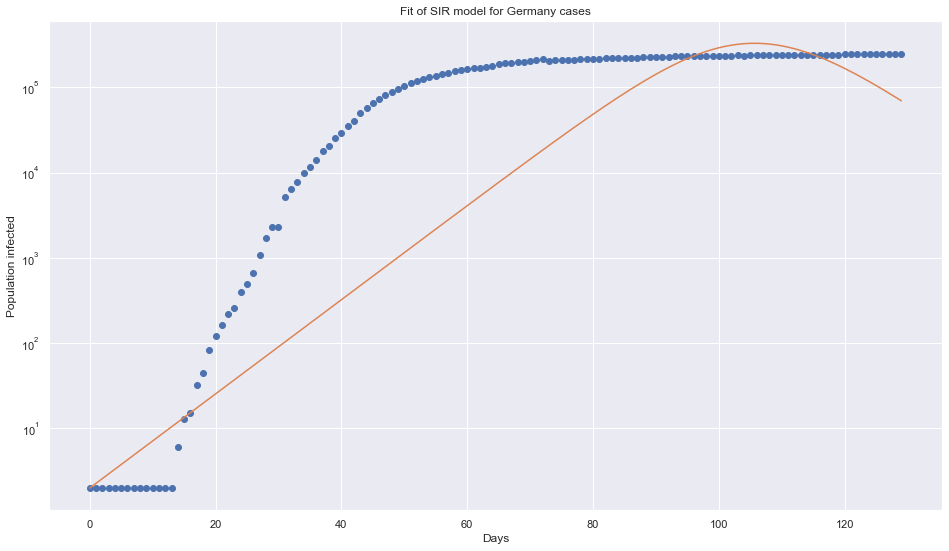

Optimal parameters: beta = 1.4265646729839006  and gamma =  1.2994200474037694
Basic Reproduction Number R0  1.0978472094794636


In [50]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])


In [53]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go
import plotly.express as px

#import os
#print(os.getcwd())
df_input_large=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')

layout ={'title':{'text':'Actual infected population and fit of SIR for countries'}}

fig = go.Figure(layout = layout)

app = dash.Dash()
app.layout = html.Div([
    
    html.Div([
    dcc.Markdown('''
    ## Select countries for visualization
    '''),


        dcc.Dropdown(
        id = 'country_drop_down',
        options = [
            {'label':'Germany', 'value':'Germany'},
            {'label':'India', 'value':'India'},
            {'label':'US', 'value':'US'},
            {'label':'Italy', 'value':'Italy'},
            {'label':'Spain','value':'Spain'}
        ],
        value= ['Germany'],
        multi = True
    )]
    ),

    html.Div([
    dcc.Graph(figure=fig, id='main_window_slope')])
])

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])

def SIR_model_figure(country_list):
    
    my_yaxis={'type':"log",
               'title':'Infected population (log-scale)'
              }
    
    traces = []
    
    for each in country_list:
            traces.append(dict(x=t,
                                y=SIR_model_data[each],
                                mode='lines',
                                opacity=0.9,
                                name=each)),
            
            traces.append(dict(x=t,
                                y=SIR_model_data[each+'_fitted'],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each,
                                ))

    return {
            'data': traces,
            'layout': dict (
                   width=1280,
                   height=720,title="Actual infected population and fit of SIR for countries",
                   legend ="List of countries",

                xaxis={'title':'Timeline (days)',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                     },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
